# Mixture Density Networks with Edward, Keras and TensorFlow

In the [previous blog post](http://cbonnett.github.io/MDN.html) we looked at what a Mixture Density Network is with an implementation in TensorFlow. We then used this to learn the distance to galaxies on a simulated data set. In this blog post we'll show an easier to write code of an MDN by combining the power of three python libraries.

1. [Edward](https://github.com/blei-lab/edward)
2. [Keras](http://keras.io/) 
3. [TensorFlow](http://tensorflow.org) 

You are likely familiar with number 2 and 3 so let me tell you a bit about the first. Edward is a python library
for probabilistic modelling, inference, and criticism. It's goal it to fuse the three related areas of Bayesian Statistics, Machine Learning, Deep Learning and Probabilistic Programming. Edward is developed by the group of [David Blei](http://www.cs.columbia.edu/~blei/) at Colombia University with the main developer being [Dustin Tran](https://twitter.com/dustinvtran). The example here we discuss based on the [example](https://github.com/blei-lab/edward/blob/master/examples/mixture_density_network.py) in the Edward repo that was written by Dustin and [myself](https://twitter.com/cbonnett) (but mainly by Dustin). 
 
Edward implements many probability distribution functions that are Tensor Flow compatible, this makes it attractive to use for MDN's. In the [previous blog post](http://cbonnett.github.io/MDN.html) we had to roll our own $Beta$ distribution, with Edward this is no longer necessary. One note to keep in mind, if you want to use Keras and TensorFlow like we will do in this post you need to set the backend of Keras to TensorFlow, [here](http://keras.io/backend/) it is explained how to do that.

Here are all the distrbutions that are implemented in Edward:

1. [Bernoulli](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L49)
2. [Beta](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L58)
3. [Binomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L68)
4. [Chi Squared](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L79)
5. [Dirichlet](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L89)
6. [Exponential](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L109)
7. [Gamma](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L118)
8. [Geometric](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L129)
9. [Inverse Gamma](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L138)
10. [log Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L155)
11. [Multinomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L165)
12. [Multivariate normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L194)
13. [Negative Binomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L283)
14. [Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L294)
15. [Poisson](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L310)
16. [Student-t](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L319)
17. [Truncated Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L333)
18. [Uniform](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L352)

Which all can be used to make a Mixture Density Networks.

In [91]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import edward as ed
import numpy as np
import tensorflow as tf

from edward.stats import norm # normal distrubtion from Edward ! 
from keras import backend as K
from keras.layers import Dense
from sklearn.cross_validation import train_test_split

## Make some toy-data to play with.

This is the same toy-data problem set as used in the [blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) by Otoro where he explains MDN's

Size of features in training data: (3000, 1)
Size of output in training data: (3000, 1)
Size of features in test data: (17000, 1)
Size of output in test data: (17000, 1)


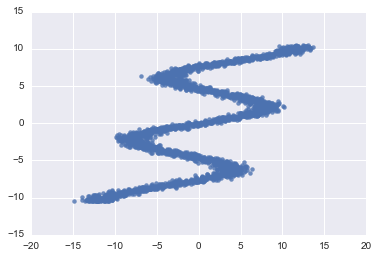

In [92]:
def build_toy_dataset(nsample=20000):
    y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, nsample))).T
    r_data = np.float32(np.random.normal(size=(nsample,1))) # random noise
    x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)
    return train_test_split(x_data, y_data, random_state=42, train_size=0.2)

X_train, X_test, y_train, y_test = build_toy_dataset()
print("Size of features in training data: {:s}".format(X_train.shape))
print("Size of output in training data: {:s}".format(y_train.shape))
print("Size of features in test data: {:s}".format(X_test.shape))
print("Size of output in test data: {:s}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False)

### Build the MDN using Keras and TF

We will define a class that can be used to construct a MDN's. We will be using a mixture of Normal Distrbutions.
The advantage of writing in class like that we can easily reuse this to build other with different amount of
mixture components. Furthermore, this make it play nicely with Edward.

In [93]:
class MixtureDensityNetwork:
    """
    Mixture density network for outputs y on inputs x.
    p((x,y), (z,theta))
    = sum_{k=1}^K pi_k(x; theta) Normal(y; mu_k(x; theta), sigma_k(x; theta))
    where pi, mu, sigma are the output of a neural network taking x
    as input and with parameters theta. There are no latent variables
    z, which are hidden variables we aim to be Bayesian about.
    """
    def __init__(self, K):
        self.K = K # here K is the amount of Mixtures 

    def mapping(self, X):
        """pi, mu, sigma = NN(x; theta)"""
        hidden1 = Dense(15, activation='relu')(X)  # fully-connected layer with 15 hidden units
        hidden2 = Dense(15, activation='relu')(hidden1) 
        self.mus = Dense(self.K)(hidden2) # the means 
        self.sigmas = Dense(self.K, activation=K.exp)(hidden2) # the variance
        self.pi = Dense(self.K, activation=K.softmax)(hidden2) # the mixture components

    def log_prob(self, xs, zs=None):
        """log p((xs,ys), (z,theta)) = sum_{n=1}^N log p((xs[n,:],ys[n]), theta)"""
        # Note there are no parameters we're being Bayesian about. The
        # parameters are baked into how we specify the neural networks.
        X, y = xs
        self.mapping(X)
        result = tf.exp(norm.logpdf(y, self.mus, self.sigmas))
        result = tf.mul(result, self.pi)
        result = tf.reduce_sum(result, 1, keep_dims=True)
        return tf.log(result)

We can set a seed in Edward so we can repdruce all random conponents, this sets the seed in numpy and TensorFlow under the [hood](https://github.com/blei-lab/edward/blob/master/edward/util.py#L191).
We use the class we defined above to initiate the MDN with 10 mixtures, this is now can be used as an Edward model.

In [94]:
ed.set_seed(42)
model = MixtureDensityNetwork(10)

In the following code cell we define the TensorFlow place holders that are then use to define the Edward data model.
The following line passed the ```model``` and ```data``` to ```MAP``` from Edward which is then used to initialise the TensorFlow variables. 


```inference = ed.MAP(model, data)```   

In [95]:
X = tf.placeholder(tf.float32, shape=(None, 1))
y = tf.placeholder(tf.float32, shape=(None, 1))
data = ed.Data([X, y]) # Make Edward Data model

inference = ed.MAP(model, data) # Make the inference model
sess = tf.Session() # start TF session 
K.set_session(sess) # pass session info to Keras
inference.initialize(sess=sess) # initialize all TF variables using the Edward interface 

Having done that we can train the MDN in TensorFlow just like we normally would, and we can get out the predictions we are interested in from the ```model``` in this case 

* ```model.pi``` the mixture components 
* ```model.mus``` the means and 
* ```model.sigmas``` for the standard  deviations.   

This is done in the last line of the code cell :
```
pred_weights, pred_means, pred_std = sess.run([model.pi, model.mus, model.sigmas], feed_dict={X: X_test})
```

The default minimisation technique used is Adam with a decaying scale factor.
This can be seen [here](https://github.com/blei-lab/edward/blob/master/edward/inferences.py#L94) in the code base of Edward. 

The loss that is minimised in the ```MAP``` model from Edward is the negative log likelihood, this is done from the 
```log_prob``` method in the MixtureDensityNetwork class we defined above. 
The ```build_loss``` method in the ```MAP``` class can be found [here](https://github.com/blei-lab/edward/blob/master/edward/inferences.py#L396). 

In [96]:
NEPOCH = 2000
train_loss = np.zeros(NEPOCH)
test_loss = np.zeros(NEPOCH)
for i in range(NEPOCH):
    _, train_loss[i] = sess.run([inference.train, inference.loss],
                                feed_dict={X: X_train, y: y_train})
    test_loss[i] = sess.run(inference.loss, feed_dict={X: X_test, y: y_test})
    #print("Train Loss: {:0.3f}, Test Loss: {:0.3f}".format(train_loss[i], test_loss[i]))
pred_weights, pred_means, pred_std = sess.run([model.pi, model.mus, model.sigmas], feed_dict={X: X_test})

We can plot the log likelihood of the training and test sample as function of training epoch.
We see that already converged after 500 training steps.

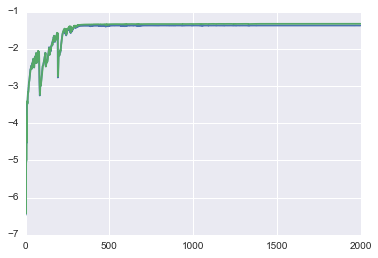

In [106]:
plt.plot(np.arange(NEPOCH), test_loss)
plt.plot(np.arange(NEPOCH), train_loss)

Next we can have a look on how some individual exmples perform.

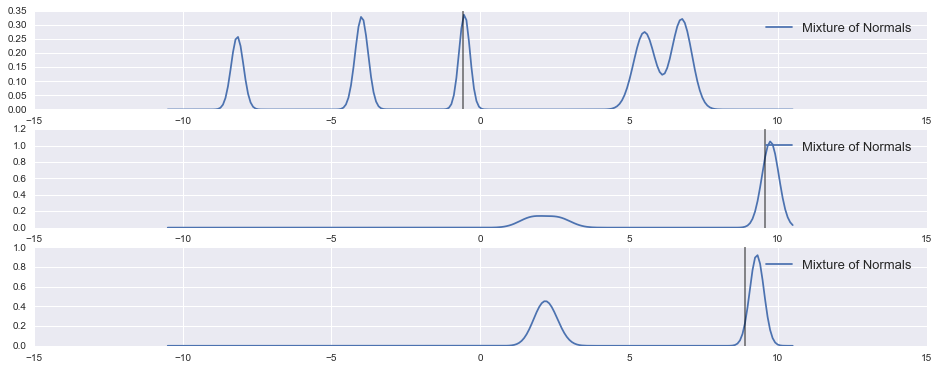

In [98]:
obj = [0, 4, 6]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6))

plot_normal_mix(pred_weights[obj][0], pred_means[obj][0], pred_std[obj][0], axes[0], comp=False)
axes[0].axvline(x=y_test[obj][0], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][2], pred_means[obj][2], pred_std[obj][2], axes[1], comp=False)
axes[1].axvline(x=y_test[obj][2], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][1], pred_means[obj][1], pred_std[obj][1], axes[2], comp=False)
axes[2].axvline(x=y_test[obj][1], color='black', alpha=0.5)

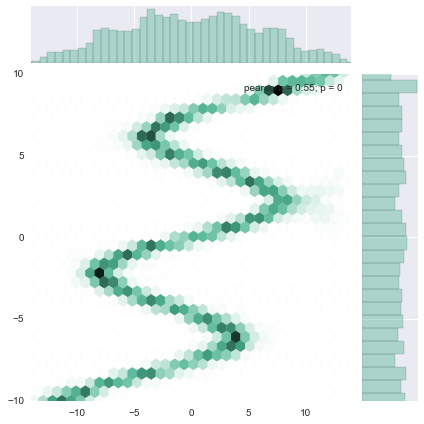

In [102]:
a = sample_from_mixture(X_test, pred_weights, pred_means, pred_std, amount=len(X_test))
sns.jointplot(a[:,0], a[:,1], kind="hex", color="#4CB391", ylim=(-10,10), xlim=(-14,14))

In [100]:
from scipy.stats import norm as normal
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """
    Plots the mixture of Normal models to axis=ax
    comp=True plots all components of mixtur model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)
    
def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """
    Draws samples from mixture model. 
    Returns 2 d array with input X and sample from prediction of Mixture Model
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j,(weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j,1]= normal.rvs(means[index], std_devs[index], size=1)
        samples[j,0]= x[j]
        if j == amount -1:
            break
    return samples

In [101]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])